In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import cyrtranslit
from sklearn import preprocessing, model_selection, metrics, feature_selection, ensemble, linear_model, cross_decomposition, feature_extraction, decomposition
from sklearn.pipeline import Pipeline
import lightgbm as lgb
color = sns.color_palette()
%matplotlib inline

In [2]:
train = pd.read_pickle('train.pkl',compression='zip')

test = pd.read_pickle('test.pkl',compression='zip')

# CountVectorizer Titles


- Since these are cyrilic, russian words, english `stopwords` wouldn't help.
- `max_df` was set as low as 0.2 and still no words were being filtered. I decided to not use it.
- Instead of using `max_features` I decided to lower the `min_df` until I got the largest number of token features I could load onto memory, converted from CSR to array in order to do PLSR, with at least 200,000 random samples to retain accuracy.
- I settled for 3000~ tokens for this step.

In [3]:
count_vec = feature_extraction.text.CountVectorizer(
    lowercase=True,
    min_df=0.0001
)
# Fitting on train and test as merged lists
count_vec.fit(train['title'].values.tolist() + test['title'].values.tolist())
print(len(count_vec.get_feature_names()))

3223


- Start working on train set.

In [4]:
# Word counts for train titles. CSR Matrix, tokens ordered alphabetically
counts = count_vec.transform(train['title'].values.tolist())

### PLSR Reduction on CSR
- PLSR doesn't handle sparse row inputs, therefore we need an array or DataFrame.
- 3000+ columns can't load to an array with 1.5Million+ rows, so I undersample to ~200,000.
- The effects of less data on accuracy were not evident by undersampling to a 10th of the original train data.

In [5]:
index = np.random.choice(len(train),size=int(2e5))

# (FIRST) Select those indices from the Sparse matrix and then turn into an array.
sample = counts[index].toarray()

### Undersampled Feature Reduction
- Another advantage of undersampling is at this step PLSR can take a long time with a million observations.

In [6]:
# More components didn't offer a significant gain 
reduce = cross_decomposition.PLSRegression(n_components=5)

# Fit undersampled array against the same indices for the target.
reduce.fit(sample,train.iloc[index].deal_probability)

# PLSR score reducing random sample of 3000~ features to 5 components.
reduce.score(sample,train.iloc[index].deal_probability)

0.17320316515390308

In [9]:
model_selection.cross_val_score(reduce,sample,train.iloc[index].deal_probability,cv=5)

array([0.14110087, 0.13587818, 0.13669251, 0.13330357, 0.1428744 ])

- After multiple iterations of N Vectors, amount of undersampling, and N of components, this was the highest score.

### Iterative Reduction on Full CSR Matrix
- Now that we have the best configuration, let's transform all the train data into those 5 components.
- We still can't load all of it as an array. Let's process this in parts, then append them.

In [10]:
# Reduce all CSR values in batches
reduced = pd.DataFrame()
lower = 0
for i,idx in enumerate(np.arange(0,int(len(train)*1.1),int(1.1e5))):
    if idx > len(train):
        idx = len(train)
    upper = idx
    if upper > lower:
        #print(lower,upper)
        sample = counts[lower:upper].toarray()
        sample = reduce.transform(sample)
        reduced = reduced.append(pd.DataFrame(sample))
        lower = idx
    else:
        lower = idx

In [11]:
reduced.shape

(1503424, 5)

In [12]:
reduced.reset_index(drop=True,inplace=True)

columns = ['title_count_{}'.format(i) for i in range(1,6)]

reduced.columns = columns

In [13]:
reduced.to_pickle('train_nlp_features.pkl',compression='zip')

- Now we can fit and predict without undersampling.

In [15]:
linear = linear_model.LinearRegression()
linear.fit(reduced,train.deal_probability)
linear.score(reduced,train.deal_probability)

0.14718865368915313

### Compare with SVD

- Another common way to reduce dimensionality in the CSR matrix is Single Value Decomposition. Let's compare it here against PLSR.

In [16]:
svd = decomposition.TruncatedSVD(n_components=200)

reduced_svd = svd.fit_transform(counts)

svd.explained_variance_ratio_.sum()

0.5691805294795375

- At 50 components, only 0.36% variance was retained. At 200, 56% variance.
- The problem with unsupervised decomposition is that all this retained variance might not be what we truly need for predictive purposes.

In [17]:
linear.fit(reduced_svd,train.deal_probability)
linear.score(reduced_svd,train.deal_probability)

0.08781668668080356

- Its abundantly clear we can get more predictive power from PLSR due to the fact that it reduces based on the target variable. SVD reduces based on internal variance, not based on any outcome variable.
- With 200 components, SVD's top scores were 0.08. At 50 components, SVD's top scores were around 0.05. At 15 components, they were around 0.02. At 5 components, (Same as plsr) they were 0.008.

## Repeat PLSR on Test Data Titles with CountVectorizer
- Now let's make the same features for test.

In [21]:
# We only do transform, since we've fit the vectorizer on combined train/test
counts = count_vec.transform(test['title'].values.tolist())

In [23]:
# Reduce all CSR values in batches
lower = 0
reduced = pd.DataFrame()
for i,idx in enumerate(np.arange(0,int(len(test)*1.1),int(1.1e5))):
    if idx > len(test):
        idx = len(test)
    upper = idx
    if upper > lower:
        sample = counts[lower:upper].toarray()
        sample = reduce.transform(sample)
        reduced = reduced.append(pd.DataFrame(sample))
        lower = idx
    else:
        lower = idx

In [24]:
reduced.shape

(508438, 5)

In [25]:
reduced.reset_index(drop=True,inplace=True)

columns = ['title_count_{}'.format(i) for i in range(1,6)]

reduced.columns = columns

In [26]:
reduced.to_pickle('test_nlp_features.pkl',compression='zip')

# CountVectorizer on Descriptions

- I already established that 3000 components are a good number for being the most I can load stably as an array of 200,000 random samples.
- Therefore I tweak vectorizer params until I get naturally as close as 3000 token features.

In [3]:
count_vec = feature_extraction.text.CountVectorizer(
    lowercase=True,
    max_df=0.2,
    min_df=0.001,
    ngram_range=(1,1)
)

- Fit both train and test descriptions.

In [4]:
count_vec.fit(train['description'].astype(str).tolist() + test['description'].astype(str).tolist())
# This will tell us the number of token features extracted
len(count_vec.get_feature_names())

3002

- Start transforming train data.

In [5]:
counts = count_vec.transform(train['description'].astype(str).tolist())

- We'll have to train PLSR again. We must undersample as well.

In [6]:
index = np.random.choice(len(train),size=int(2e5))

# (FIRST) Select those indices from the Sparse matrix and then turn into an array.
sample = counts[index].toarray()

In [7]:
# More components didn't offer a significant gain 
reduce = cross_decomposition.PLSRegression(n_components=10)

# Fit undersampled array against the same indices for the target.
reduce.fit(sample,train.iloc[index].deal_probability)

# PLSR score reducing random sample of 3000~ features to N components.
reduce.score(sample,train.iloc[index].deal_probability)

0.13152567009083782

- It looks like titles are more predictive than descriptions. 13 vs 17
- At 5 components, score was 12. At 10 components, score was 13. At 15 components, it was still 13. Therefore I left it at 10 components.

In [8]:
# Reduce all CSR values in batches
reduced = pd.DataFrame()
lower = 0
for i,idx in enumerate(np.arange(0,int(len(train)*1.1),int(1.1e5))):
    if idx > len(train):
        idx = len(train)
    upper = idx
    if upper > lower:
        #print(lower,upper)
        sample = counts[lower:upper].toarray()
        sample = reduce.transform(sample)
        reduced = reduced.append(pd.DataFrame(sample))
        lower = idx
    else:
        lower = idx

In [9]:
reduced.reset_index(drop=True,inplace=True)

columns = ['desc_count_{}'.format(i) for i in range(1,11)]

reduced.columns = columns

In [10]:
reduced.shape

(1503424, 10)

In [11]:
train_nlp_features = pd.read_pickle('train_nlp_features.pkl',compression='zip')

In [12]:
train_nlp_features = train_nlp_features.join(reduced)

In [13]:
train_nlp_features.to_pickle('train_nlp_features.pkl',compression='zip')

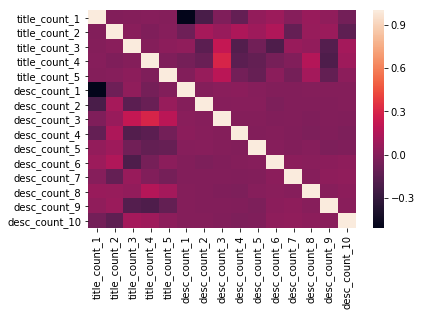

In [14]:
correlation = train_nlp_features.corr()

sns.heatmap(correlation)
plt.show()

- From the heatmap, both sets of features are uncorrelated with their same set. But features of either set may be correlated with features of the other set.

## Description Counts on Test Data

In [15]:
counts = count_vec.transform(test['description'].astype(str).tolist())

In [16]:
# Reduce all CSR values in batches
reduced = pd.DataFrame()
lower = 0
for i,idx in enumerate(np.arange(0,int(len(test)*1.1),int(1.1e5))):
    if idx > len(test):
        idx = len(test)
    upper = idx
    if upper > lower:
        #print(lower,upper)
        sample = counts[lower:upper].toarray()
        sample = reduce.transform(sample)
        reduced = reduced.append(pd.DataFrame(sample))
        lower = idx
    else:
        lower = idx

In [17]:
reduced.shape

(508438, 10)

In [18]:
reduced.reset_index(drop=True,inplace=True)

columns = ['desc_count_{}'.format(i) for i in range(1,11)]

reduced.columns = columns

In [19]:
test_nlp_features = pd.read_pickle('test_nlp_features.pkl',compression='zip')

In [20]:
test_nlp_features = test_nlp_features.join(reduced)

In [21]:
test_nlp_features.to_pickle('test_nlp_features.pkl',compression='zip')

## Evaluate Features

In [37]:
linear.fit(train_nlp_features,train.deal_probability)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [38]:
linear.score(train_nlp_features,train.deal_probability)

0.17297229296795916

# TFIDFVectorizer

In [23]:
count_vec = feature_extraction.text.TfidfVectorizer(
    lowercase=True,
    min_df=0.0001
)
# Fitting on train and test as merged lists
count_vec.fit(train['title'].values.tolist() + test['title'].values.tolist())
print(len(count_vec.get_feature_names()))

3223


In [24]:
# Word counts for train titles. CSR Matrix, tokens ordered alphabetically
counts = count_vec.transform(train['title'].values.tolist())

In [51]:
index = np.random.choice(len(train),size=int(1.2e5))

# (FIRST) Select those indices from the Sparse matrix and then turn into an array.
sample = counts[index].toarray()

In [52]:
# More components didn't offer a significant gain 
reduce = cross_decomposition.PLSRegression(n_components=5)

# Fit undersampled array against the same indices for the target.
reduce.fit(sample,train.iloc[index].deal_probability)

# PLSR score reducing random sample of 3000~ features to 5 components.
reduce.score(sample,train.iloc[index].deal_probability)

0.19251023390966104

In [53]:
sample = reduce.transform(sample)

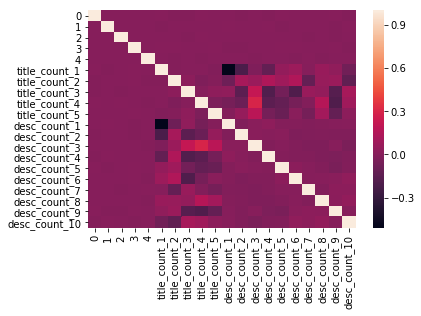

In [31]:
sns.heatmap(pd.DataFrame(sample).join(train_nlp_features).corr())
plt.show()

In [54]:
model_selection.cross_val_score(cv=3,estimator=linear,X=sample,y=train.iloc[index].deal_probability)

array([0.19031122, 0.18468344, 0.20180731])

In [61]:
#sample = pd.DataFrame(sample).join(train_nlp_features)

model_selection.cross_val_score(cv=10,
                                estimator=linear,
                                X=pd.DataFrame(sample).join(train_nlp_features),
                                y=train.iloc[index].deal_probability)

array([0.19024898, 0.18401111, 0.19484201, 0.18431953, 0.18104632,
       0.18437213, 0.19518818, 0.20102509, 0.20213784, 0.2043796 ])